# This notebook will:
 - create a pixel 'footprint' of a TESS CCD, tracing around the outer pixels
 - using tesspoint (tess_stars2px.py), create a list of tess ra, dec from the footprint for a given sector/camera/ccd
 - using a list of sectors/cameras/ccd's, iterate over all possibilities
 - write this to a file

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import subprocess
import multiprocessing
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

# First, we generate the footprint for a TESS CCD
 - TESS CCD's are 2048 x 2048, indexed from 0-2047
 - For this case, I've chosen the footprint to trace the CENTER of the outer pixel of the TESS CCD
 - Therefore our four corners should be:  
```
    (0.5, 2047.5)------------(2047.5, 2047.5)  
        |                             |  
        |                             |  
        |                             |  
        |                             |  
        |                             |  
    (0.5, 0.5)-----------------(2047.5, 0.5)  
```



In [2]:
def footprint(npoints=20):
    """Gets the column and row points for CCD edges"""
    column = np.hstack(
        [
            np.ones(npoints)*0.5,
            np.linspace(0.5, 2047.5, npoints),
            np.linspace(0.5, 2047.5, npoints),
            np.ones(npoints) * 2047.5,
        ]
    )
    row = np.hstack(
        [
            np.linspace(0.5, 2047.5, npoints),
            np.ones(npoints)*0.5,
            np.ones(npoints) * 2047.5,
            np.linspace(0.5, 2047.5, npoints),
        ]
    )
    return np.vstack([column, row]).T

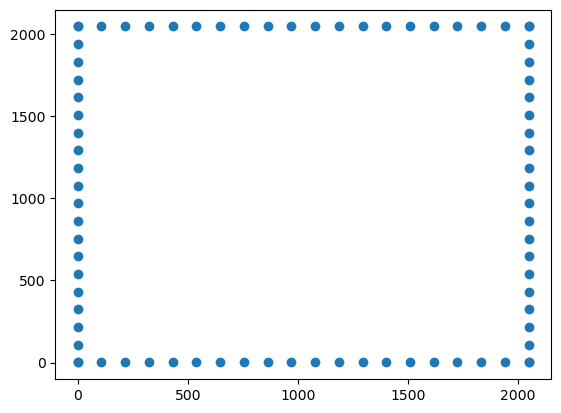

In [12]:
footie=footprint()
plt.scatter(footie[:,0],footie[:,1])

# We'll take this footprint and x,y -> ra, eec for each sector/camera/ccd
Using tesspoint (tess_stars2px.py), we can only do this for a single point and iterate.  To speed this up we'll use multiprocessing/pool.  The functions defined here (footprint and multi_create_footie_df) and dependencies are in a separate file to enable this since pool doesn't recognize functions from jupyter cells well.  

In the future this will be unescessary and the vectorized tess-point can do this calculation on a whole footprint trivially.  

In [7]:
def multi_create_footie_df(SectorCameraCCD):
    Sector, Camera, CCD = SectorCameraCCD
    xy=footprint()
    tic=range(len(xy[:,0]))
    ra=[]
    dec=[]
    
    for tic, x, y in zip(tic, xy[:,0], xy[:,1]):
        point=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-r",str(Sector),str(Camera),str(CCD),str(x),str(y)],capture_output=True,text=True)
        ra.append(float(point.stdout.split(' ')[0]))
        dec.append(float(point.stdout.split(' ')[1]))
    
    footie_df=pd.DataFrame(data={'id':tic, 'ra':ra, 'dec':dec, 'col':xy[:,0],'row':xy[:,1],
                        'sector':Sector,'camera':Camera,'ccd':CCD})
    return footie_df

from testfun import multi_create_footie_df, footprint
# the tessfun.py file has the import subprocess/pandas/numpy and 
# footprint and multi_create_footie_df functions defined here inside of it
# multiprocess doesn't work well with funcitons defined in notebooks
# couldn't get the tess_stars2px.py reverse function to work without
# iterating through each point indivudally, so.  

# We'll define our ranges here:

In [8]:
Camera_list=[1,2,3,4]
CCD_list=[1,2,3,4]
Sector_list = range(1,69)
inlist=list(product(Sector_list,Camera_list,CCD_list))

# And execute the multiprocessing here:

In [9]:
from multiprocessing.pool import Pool
pool=Pool()
comb_df=pd.DataFrame(data={'id':[], 'ra':[], 'dec':[], 'col':[],'row':[],
                        'sector':[],'camera':[],'ccd':[]})
for result in pool.map(multi_create_footie_df, inlist):
    comb_df=pd.concat([comb_df, result])
pool.close()

# File saved to:

In [10]:
comb_df.to_csv('TESSFootprint_SectorCameraCCD.csv')